In [ ]:
import os
import numpy as np
import soundfile as sf
import librosa
from pathlib import Path

def extract_mfcc(signal, samplerate=16000, n_mfcc=20, winlen=0.025, winstep=0.01):
    hop_length = int(samplerate * winstep)
    win_length = int(samplerate * winlen)

    mfcc = librosa.feature.mfcc(
        y=signal,
        sr=samplerate,
        n_mfcc=n_mfcc,
        n_fft=512,
        hop_length=hop_length,
        win_length=win_length,
        window="hamming",
        center=False
    )
    mfcc = mfcc.T
    return mfcc

def process_odss_mfcc_style(dataset_path, output_path, sr=16000):
    dataset_path = Path(dataset_path)
    output_path = Path(output_path)
    output_path.mkdir(exist_ok=True)

    class_map = {
        "natural": "bonafide",
        "fastpitch-hifigan": "spoof",
        "vits": "spoof"
    }

    total = 0
    skipped = 0

    for subfolder, label in class_map.items():
        audio_dir = dataset_path / subfolder
        out_dir_base = output_path / label / subfolder

        for wav_file in audio_dir.rglob("*.wav"):
            try:
                signal, rate = sf.read(str(wav_file))
                if rate != sr:
                    print(f"[!] Skipping {wav_file.name}: Sample rate {rate} ≠ {sr}")
                    skipped += 1
                    continue

                mfcc_feat = extract_mfcc(signal, samplerate=sr)
                rel_path = wav_file.relative_to(audio_dir).with_suffix(".npy")
                out_file = out_dir_base / rel_path
                out_file.parent.mkdir(parents=True, exist_ok=True)

                np.save(out_file, mfcc_feat)
                total += 1
                print(f"[✓] Saved MFCC: {out_file}")
            except Exception as e:
                print(f"[X] Failed {wav_file.name}: {e}")
                skipped += 1

process_odss_mfcc_style(
    dataset_path=r"C:\Users\DaysPC\Documents\Datasets\odss",
    output_path=r"C:\Users\DaysPC\Documents\Datasets\odss_mfcc"
)

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path

class ODSSFeatureDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_len=400, expected_dim=20):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.max_len = max_len
        self.expected_dim = expected_dim
        self.samples = []

        for label_str in ['bonafide', 'spoof']:
            label = 1 if label_str == 'bonafide' else 0
            for npy_file in (self.root_dir / label_str).rglob("*.npy"):
                self.samples.append((npy_file, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        try:
            feat = np.load(path)
        except Exception as e:
            print(f"[ERROR] Could not load {path.name}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        if feat.ndim != 2 or feat.shape[1] != self.expected_dim:
            print(f"[WARN] Invalid feature shape: {path.name} -> {feat.shape}")
            return self.__getitem__((idx + 1) % len(self))

        if feat.shape[0] < self.max_len:
            feat = np.pad(feat, ((0, self.max_len - feat.shape[0]), (0, 0)), mode='constant')
        else:
            feat = feat[:self.max_len, :]

        tensor = torch.tensor(feat, dtype=torch.float32).unsqueeze(0)
        return tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
from torch.utils.data import DataLoader, random_split

dataset_path = r"C:\Users\DaysPC\Documents\Datasets\odss_mfcc"

dataset = ODSSFeatureDataset(
    root_dir=dataset_path,
    expected_dim=20
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [15]:
for x, y in train_loader:
    print(f"MFCC shape: {x.shape}")
    print(f"Labels: {y}")
    break

MFCC shape: torch.Size([16, 1, 400, 20])
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

In [ ]:
class ResNetLFCC(nn.Module):
    def __init__(self, block=BasicBlock, layers=[2,2,2,2], num_classes=2):
        super(ResNetLFCC, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [18]:
model = ResNetLFCC()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetLFCC(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
best_val_acc = 0.0
save_path = "resnet_mfcc.pth"

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)


Epoch 1/10


Validating: 100%|██████████| 376/376 [01:16<00:00,  4.89it/s]


Train Loss: 0.3059 | Accuracy: 85.96%
Val   Loss: 0.2349 | Accuracy: 90.19%

Epoch 2/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.42it/s]


Train Loss: 0.1881 | Accuracy: 92.23%
Val   Loss: 0.1860 | Accuracy: 92.81%

Epoch 3/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.34it/s]


Train Loss: 0.1526 | Accuracy: 93.96%
Val   Loss: 0.1190 | Accuracy: 95.42%

Epoch 4/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.84it/s]


Train Loss: 0.1310 | Accuracy: 94.92%
Val   Loss: 0.1604 | Accuracy: 93.51%

Epoch 5/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.39it/s]


Train Loss: 0.1056 | Accuracy: 95.76%
Val   Loss: 0.0969 | Accuracy: 96.17%

Epoch 6/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.90it/s]


Train Loss: 0.0938 | Accuracy: 96.30%
Val   Loss: 0.0991 | Accuracy: 95.99%

Epoch 7/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 42.62it/s]


Train Loss: 0.0764 | Accuracy: 97.01%
Val   Loss: 0.1216 | Accuracy: 95.12%

Epoch 8/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.71it/s]


Train Loss: 0.0707 | Accuracy: 97.29%
Val   Loss: 0.1110 | Accuracy: 95.99%

Epoch 9/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.77it/s]


Train Loss: 0.0642 | Accuracy: 97.46%
Val   Loss: 0.0802 | Accuracy: 96.95%

Epoch 10/10


Validating: 100%|██████████| 376/376 [00:08<00:00, 43.31it/s]

Train Loss: 0.0511 | Accuracy: 98.06%
Val   Loss: 0.0825 | Accuracy: 96.87%


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

def evaluate_scores(model, loader, device):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_scores), np.array(all_labels)

In [ ]:
import matplotlib.pyplot as plt

def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer * 100, eer_threshold

In [ ]:
def plot_confusion(y_true, y_pred, labels=["Spoof", "Bonafide"]):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")

In [25]:
scores, labels = evaluate_scores(model, val_loader, device)

eer, threshold = compute_eer(labels, scores)
print(f"\nEqual Error Rate (EER): {eer:.2f}%")

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

y_pred = (scores >= threshold).astype(int)
plot_confusion(labels, y_pred)



Equal Error Rate (EER): 3.15%
AUC: 0.996

Confusion Matrix:
[[3633  118]
 [  70 2184]]


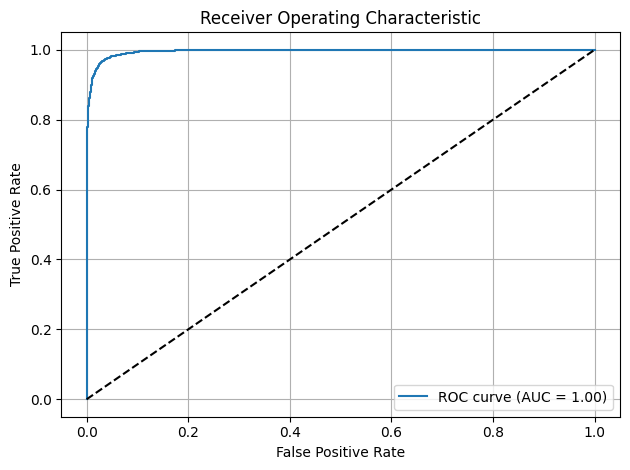

In [26]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

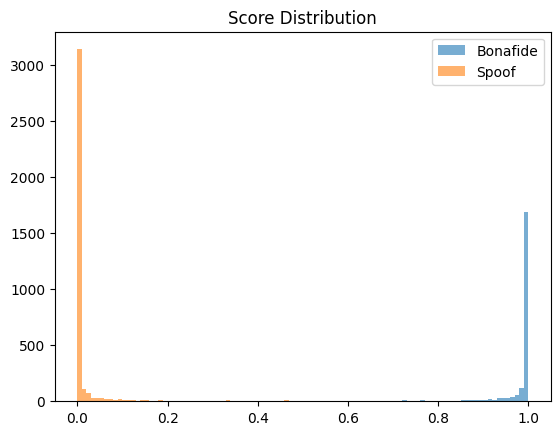

In [27]:
plt.hist(scores[labels == 1], bins=100, alpha=0.6, label="Bonafide")
plt.hist(scores[labels == 0], bins=100, alpha=0.6, label="Spoof")
plt.legend()
plt.title("Score Distribution")
plt.show()